In [38]:
import pandas as pd
import os
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [56]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision.models as models

In [34]:
# Get train and test images names
df_train_images = pd.read_csv('./flickr8k/annotations/trainImages.csv', names=['filename'])
df_test_images = pd.read_csv('./flickr8k/annotations/testImages.csv', names=['filename'])

print(f"Train shape: {df_train_images.shape}")
print(f"Test shape: {df_test_images.shape}")

Train shape: (6000, 1)
Test shape: (1000, 1)


In [ ]:
# Split images in train and test folders
# 6000 train images and 1000 test images

imagesPath = './flickr8k/images/'
trainPath = imagesPath + 'train/'
testPath = imagesPath + 'test/' 
images = os.listdir(imagesPath)

for im in images[:10]:
    
    for file in df_train_images['filename']:
        if file == im:
            print(file + ' / ' + im)
            fullpath = imagesPath + im
            os.system('cp ' + fullpath + ' ' + trainPath)
            
    for file in df_test_images['filename']:
        if file == im:
            print(file + ' / ' + im)
            fullpath = imagesPath + im
            os.system('cp ' + fullpath + ' ' + testPath)

In [17]:
df_captions = pd.read_csv('./flickr8k/annotations/annotations_image_id.csv', sep=';')

df_captions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40460 entries, 0 to 40459
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  40460 non-null  object
 1   caption   40460 non-null  object
dtypes: object(2)
memory usage: 632.3+ KB


In [19]:
df_captions.head(10)

,image_id,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with...
7,1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots a...
8,1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each o...
9,1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .


In [34]:
# Show one sample of dataset
def showSample(image_name):
    
    res = df_captions.loc[df_captions['image_id'] == image_name]
    
    print(f"Image name: {image_name}")
    
    for i in range(len(res)):
        print(f"Caption {i}: {res.iloc[i, 1]}")
    
showSample('1000268201_693b08cb0e.jpg')

Image name: 1000268201_693b08cb0e.jpg
Caption 0: A child in a pink dress is climbing up a set of stairs in an entry way .
Caption 1: A girl going into a wooden building .
Caption 2: A little girl climbing into a wooden playhouse .
Caption 3: A little girl climbing the stairs to her playhouse .
Caption 4: A little girl in a pink dress going into a wooden cabin .


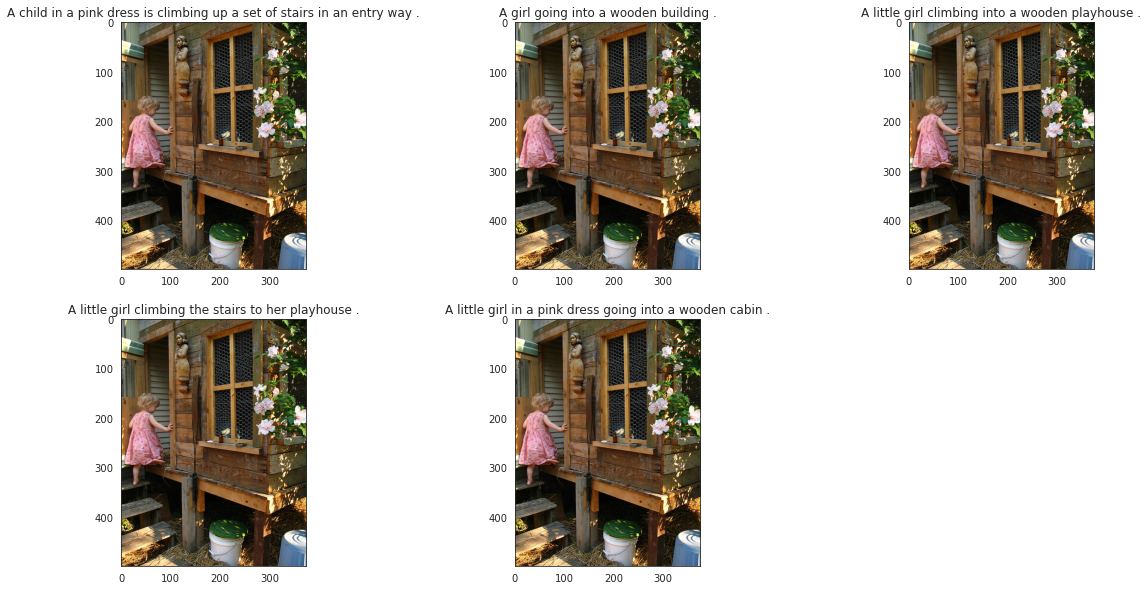

In [43]:
def showCaptionImage(image_name):
    """Show image with its captions"""
    image = plt.imread('./flickr8k/images/' + image_name)
    captions = df_captions.loc[df_captions['image_id'] == image_name].iloc[:, 1]
    
    with sns.axes_style("white"): 
        plt.figure(figsize=(20, 10))
        for i, caption in enumerate(captions):
            fig = plt.subplot(2, 3, i + 1)
            plt.imshow(image)
            plt.title(caption)
    
showCaptionImage('1000268201_693b08cb0e.jpg')

In [48]:
class ImageCaptioningDataset(Dataset):
    """Image captioning dataset"""
    
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file(string): captions file
            root_dir(string): images directory
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        self.df_captions = pd.read_csv(csv_file, sep=';')
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        """Length is nb_captions / captions_per_image"""
        return len(self.df_captions) / 5
        
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
            
        im_name = self.df_captions.iloc[index, 0]
        im_path = os.path.join(self.root_dir, im_name)
        image = io.imread(im_path)
        
        captions = self.df_captions.loc[self.df_captions['image_id'] == im_name].iloc[:, 1]
        captions = np.array(captions)
        
        sample = {'image': image, 'captions': captions}

        if self.transform:
            sample = self.transform(sample)

        return sample     

In [66]:
class Rescale(object):
    """Rescale the image in a sample to a given size. Usefull to have all samples of same shape in input of a CNN

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image = sample['image']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        return {'image': img, 'captions': sample['captions']}

class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, captions = sample['image'], sample['captions']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]


        return {'image': image, 'captions': captions}
    
class ToTensor(object):
    """Convert ndarrays in a sample to Tensors."""

    def __call__(self, sample):
        image, captions = sample['image'], sample['captions']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'captions': captions}

In [67]:
# Instanciate train dataset

training_set = ImageCaptioningDataset(
    './flickr8k/annotations/annotations_image_id.csv', 
    './flickr8k/images/train/', 
    transform=transforms.Compose([Rescale(256), RandomCrop(224), ToTensor()])
)

print(training_set[0])

{'image': tensor([[[0.2764, 0.3205, 0.3889,  ..., 0.0773, 0.0708, 0.0800],
         [0.2478, 0.2884, 0.3556,  ..., 0.0879, 0.1296, 0.1957],
         [0.2280, 0.3035, 0.3749,  ..., 0.1617, 0.1087, 0.1135],
         ...,
         [0.1999, 0.0872, 0.0925,  ..., 0.1650, 0.1475, 0.1345],
         [0.2877, 0.0588, 0.0274,  ..., 0.2006, 0.1423, 0.1255],
         [0.0381, 0.0462, 0.1091,  ..., 0.1126, 0.1285, 0.0876]],

        [[0.2864, 0.2900, 0.3252,  ..., 0.1509, 0.1392, 0.1245],
         [0.2572, 0.2625, 0.3020,  ..., 0.1083, 0.1584, 0.2470],
         [0.2409, 0.2800, 0.3243,  ..., 0.2711, 0.2528, 0.2646],
         ...,
         [0.1943, 0.0541, 0.0749,  ..., 0.1164, 0.1038, 0.1142],
         [0.2942, 0.0508, 0.0353,  ..., 0.1155, 0.0974, 0.0865],
         [0.0297, 0.0509, 0.0762,  ..., 0.1174, 0.0760, 0.0733]],

        [[0.2686, 0.2317, 0.2649,  ..., 0.0728, 0.0369, 0.0189],
         [0.2145, 0.1821, 0.2225,  ..., 0.0571, 0.0464, 0.0609],
         [0.1958, 0.2046, 0.2096,  ..., 0.1198, 

In [59]:
# Creating a pretrained cnn model instance

vgg16 = models.vgg16()